# Heart Disease Risk Prediction Using Logistic Regression

This notebook implements logistic regression from scratch to predict the risk of heart disease. The dataset is taken from Kaggle and contains clinical information of patients.

In this notebook we will: 
1. Load and prepare the dataset
2. Implement logistic regression
3. Visualize decision boundaries
4. Add regularization

---

## 0. Import libraries 

In [37]:
%pip install numpy pandas matplotlib 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Load and prepare the dataset


### 1.1 Load the dataset

In [39]:
df = pd.read_csv('heart.csv')
print("Data loaded successfully.")

Data loaded successfully.


### 1.2 Show first rows

In [40]:
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [41]:
df.shape #(patients, features)

(270, 14)

### 1.3 Check unique values in the target column

This shows how many patients:

- Have heart disease

- Do not have heart disease

In [42]:
df['Heart Disease'].value_counts()

Heart Disease
Absence     150
Presence    120
Name: count, dtype: int64

### 1.4 Binarizing the target column

The target column "Heart Disease" has text values:
- "Presence" -> patient has heart disease
- "Absence" -> patient does not have heart disease

Logistic regression needs numeric values.
We convert:
- Presence -> 1
- Absence -> 0

In [43]:
# Convert target column to binary
df['Heart Disease'] = df['Heart Disease'].map({
    'Presence': 1,
    'Absence': 0
})

# Check results
df['Heart Disease'].value_counts()

Heart Disease
0    150
1    120
Name: count, dtype: int64

#### 1.5 Target proportion

In [44]:
df['Heart Disease'].value_counts(normalize=True) * 100

Heart Disease
0    55.555556
1    44.444444
Name: proportion, dtype: float64

The target proportion indicates the percentage of patients with and without heart disease. This helps us understand the class distribution in the dataset. A moderately balanced dataset, like this one, ensures that the model does not become biased towards one class, which is crucial for reliable predictions.

#### 1.6 Class distribution plot

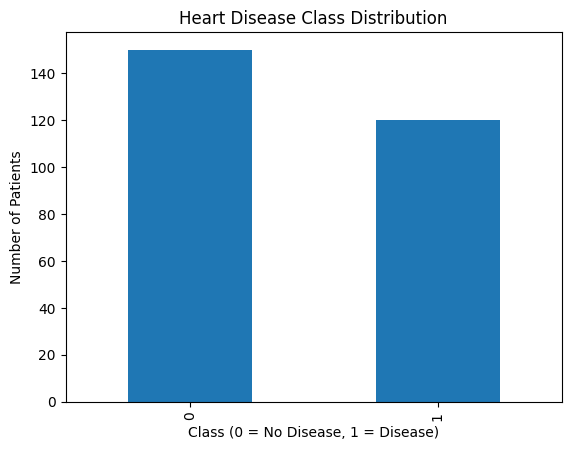

In [45]:
df['Heart Disease'].value_counts().plot(kind='bar')
plt.title("Heart Disease Class Distribution")
plt.xlabel("Class (0 = No Disease, 1 = Disease)")
plt.ylabel("Number of Patients")
plt.show()

## 2. Exploratory Data Analysis (EDA)

### 2.1 Summary statistics

In [46]:
df.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


### 2.2 Check for missing values

Count missing values in each column

In [47]:
df.isnull().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

### 2.3 Check for outliers

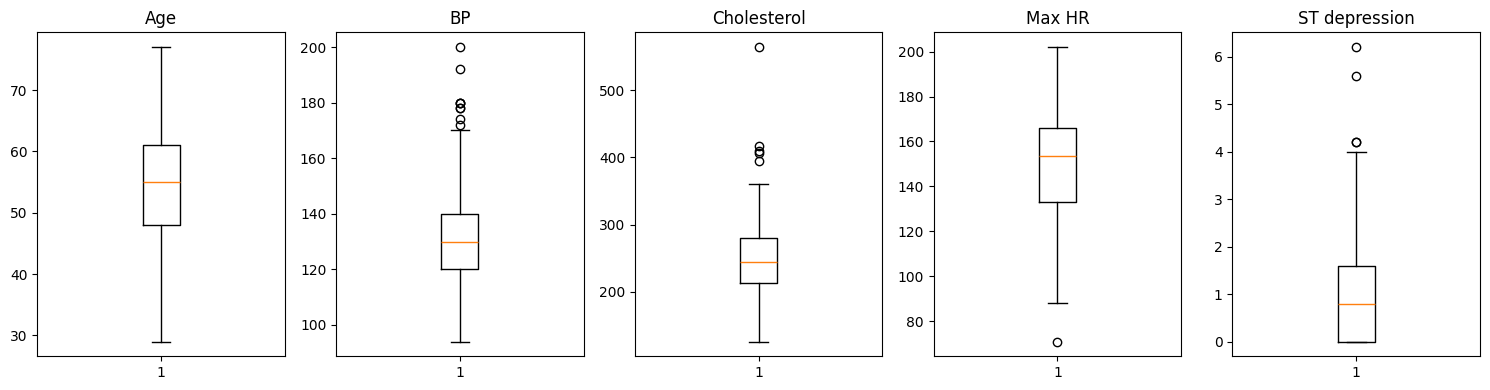

In [48]:
numerical_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression'] # Boxplots

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

Some outliers are visible especially in Cholesterol. For this lab, we keep all data since outliers may represent real patient conditions.

---

## 3. Data Preparation

### 3.1 Select features

We select 6 important clinical features for our model:
- **Age**: Patient age
- **Cholesterol**: Cholesterol level
- **BP**: Blood pressure
- **Max HR**: Maximum heart rate
- **ST depression**: ST depression induced by exercise
- **Number of vessels fluro**: Number of major vessels colored by fluoroscopy

In [49]:
features = ['Age', 'Cholesterol', 'BP', 'Max HR', 'ST depression', 'Number of vessels fluro']

X = df[features].values
y = df['Heart Disease'].values

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (270, 6)
Target shape: (270,)


### 3.2 Train/Test split

We split the data keeping the same proportion of disease/no-disease in both sets.

In [50]:
np.random.seed(42)

# Separate indices by class
idx_class_0 = np.where(y == 0)[0]
idx_class_1 = np.where(y == 1)[0]

# Shuffle indices
np.random.shuffle(idx_class_0)
np.random.shuffle(idx_class_1)

# Split each class 70/30
split_0 = int(0.7 * len(idx_class_0))
split_1 = int(0.7 * len(idx_class_1))

train_idx = np.concatenate([idx_class_0[:split_0], idx_class_1[:split_1]])
test_idx = np.concatenate([idx_class_0[split_0:], idx_class_1[split_1:]])

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train set size:", len(X_train))
print("Test set size:", len(X_test))
print("Train disease rate:", y_train.mean() * 100, "%")
print("Test disease rate:", y_test.mean() * 100, "%")

Train set size: 189
Test set size: 81
Train disease rate: 44.44444444444444 %
Test disease rate: 44.44444444444444 %


### 3.3 Normalize numerical features

Normalization scales all features to a similar range. This helps gradient descent converge faster.

In [51]:
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

X_train_norm = (X_train - train_mean) / train_std
X_test_norm = (X_test - train_mean) / train_std

print("Training set normalized.")
print("Sample of normalized training data:")
print(X_train_norm[:3])

Training set normalized.
Sample of normalized training data:
[[-0.91125832 -1.3185691   0.5916325   0.43215038  0.31304113 -0.70475712]
 [ 1.86303006  0.33468693 -1.21827815 -0.92010826 -0.94196923  0.42404878]
 [-2.79777442 -0.81132009 -0.08708399  2.32531248 -0.94196923 -0.70475712]]


---
## 4. Implement Basic Logistic Regression

### 4.1 Sigmoid function

The sigmoid function converts any value to a probability between 0 and 1.

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

In [52]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

test_values = np.array([-10, -1, 0, 1, 10])
print("Sigmoid test:")
print("Input:", test_values)
print("Output:", sigmoid(test_values))

Sigmoid test:
Input: [-10  -1   0   1  10]
Output: [4.53978687e-05 2.68941421e-01 5.00000000e-01 7.31058579e-01
 9.99954602e-01]


### 4.2 Cost function (Binary Cross-Entropy)

The cost function measures how wrong our predictions are.

$$J(w,b) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right]$$

In [53]:
def compute_cost(X, y, w, b):
    m = len(y)
    z = np.dot(X, w) + b
    y_pred = sigmoid(z)
    
    # Avoid log(0) by clipping values
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    cost = -1/m * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    return cost

### 4.3 Gradient Descent

Gradient descent updates weights to minimize the cost. The gradients are:

$$\frac{\partial J}{\partial w} = \frac{1}{m} X^T (\hat{y} - y)$$

$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum (\hat{y} - y)$$

In [54]:
def gradient_descent(X, y, w, b, alpha, iterations):
    m = len(y)
    cost_history = []
    
    for i in range(iterations):
        z = np.dot(X, w) + b
        y_pred = sigmoid(z)
        
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        
        w = w - alpha * dw
        b = b - alpha * db
        
        if i % 100 == 0:
            cost = compute_cost(X, y, w, b)
            cost_history.append(cost)
    
    return w, b, cost_history

### 4.4 Train the model

We train with learning rate α = 0.01 and 1000 iterations.

In [55]:
n_features = X_train_norm.shape[1]
w = np.zeros(n_features)
b = 0

alpha = 0.01
iterations = 1000

# Train the model
w, b, cost_history = gradient_descent(X_train_norm, y_train, w, b, alpha, iterations)

print("Training complete")
print("Final weights (w):", w)
print("Final bias (b):", b)

Training complete
Final weights (w): [-0.07188915  0.09333729  0.10392364 -0.57740194  0.56125769  0.7631357 ]
Final bias (b): -0.187852731997005


### 4.5 Cost vs Iterations plot

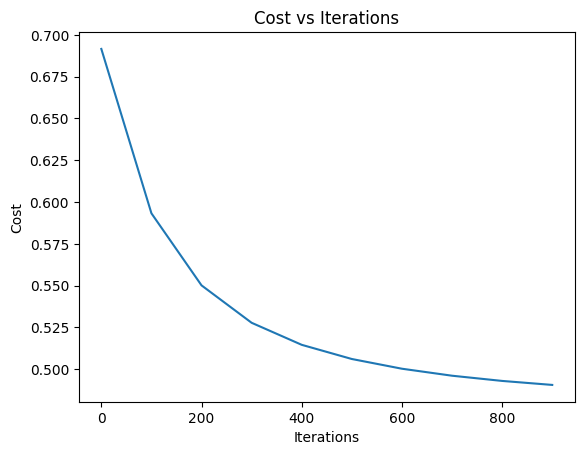

Initial cost: 0.6916288206486229
Final cost: 0.4905339729850101


In [56]:
plt.plot(range(0, iterations, 100), cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost vs Iterations")
plt.show()

print("Initial cost:", cost_history[0])
print("Final cost:", cost_history[-1])

### 4.6 Make predictions

We use threshold = 0.5: if probability ≥ 0.5, predict disease (1), otherwise no disease (0).

In [57]:
def predict(X, w, b, threshold=0.5):
    z = np.dot(X, w) + b
    probabilities = sigmoid(z)
    predictions = (probabilities >= threshold).astype(int)
    return predictions

y_train_pred = predict(X_train_norm, w, b)
y_test_pred = predict(X_test_norm, w, b)

### 4.7 Evaluation metrics

We calculate:
- **Accuracy**: % of correct predictions
- **Precision**: Of predicted positives, how many are truly positive
- **Recall**: Of actual positives, how many did we catch
- **F1 Score**: Harmonic mean of precision and recall

In [58]:
def calculate_metrics(y_true, y_pred):
    # True positives, false positives, true negatives, false negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1

# metrics for train set
train_acc, train_prec, train_rec, train_f1 = calculate_metrics(y_train, y_train_pred)

# metrics for test set
test_acc, test_prec, test_rec, test_f1 = calculate_metrics(y_test, y_test_pred)

### 4.8 Metrics table

In [59]:
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [train_acc, train_prec, train_rec, train_f1],
    'Test': [test_acc, test_prec, test_rec, test_f1]
})

metrics_df['Train'] = (metrics_df['Train'] * 100).round(2)
metrics_df['Test'] = (metrics_df['Test'] * 100).round(2)

print("Performance Metrics (%):")
metrics_df

Performance Metrics (%):


,Metric,Train,Test
0,Accuracy,77.25,85.19
1,Precision,78.87,85.29
2,Recall,66.67,80.56
3,F1 Score,72.26,82.86


### 4.9 Interpretation of weights

The weights show the importance and direction of each feature:

In [60]:
weights_df = pd.DataFrame({
    'Feature': features,
    'Weight': w.round(4)
})
weights_df = weights_df.sort_values('Weight', ascending=False)
print("Feature weights (sorted by importance):")
weights_df

Feature weights (sorted by importance):


,Feature,Weight
5,Number of vessels fluro,0.7631
4,ST depression,0.5613
2,BP,0.1039
1,Cholesterol,0.0933
0,Age,-0.0719
3,Max HR,-0.5774


---
## 5. Visualize Decision Boundaries

A **decision boundary** is the line that separates the two classes (disease vs no disease). Since we can only visualize in 2D, we train separate models using only 2 features at a time.

**Why is this useful?**
- Helps us see how well the features separate the classes
- Shows if the relationship is linear (straight line) or needs more complex models

### 5.1 Define feature pairs to visualize

We select 3 clinically meaningful pairs:
1. **Age vs Cholesterol**: Both are major risk factors
2. **BP vs Max HR**: Cardiovascular indicators  
3. **ST Depression vs Number of Vessels**: Direct heart condition indicators

In [61]:
feature_pairs = [
    ('Age', 'Cholesterol'),
    ('BP', 'Max HR'),
    ('ST depression', 'Number of vessels fluro')
]

print("Feature pairs selected for visualization:")
for i, pair in enumerate(feature_pairs, 1):
    print(f"  {i}. {pair[0]} vs {pair[1]}")

Feature pairs selected for visualization:
  1. Age vs Cholesterol
  2. BP vs Max HR
  3. ST depression vs Number of vessels fluro


### 5.2 Plot decision boundaries

For each pair, we:
1. Extract only those 2 features
2. Normalize them
3. Train a new logistic regression model
4. Draw the decision boundary line

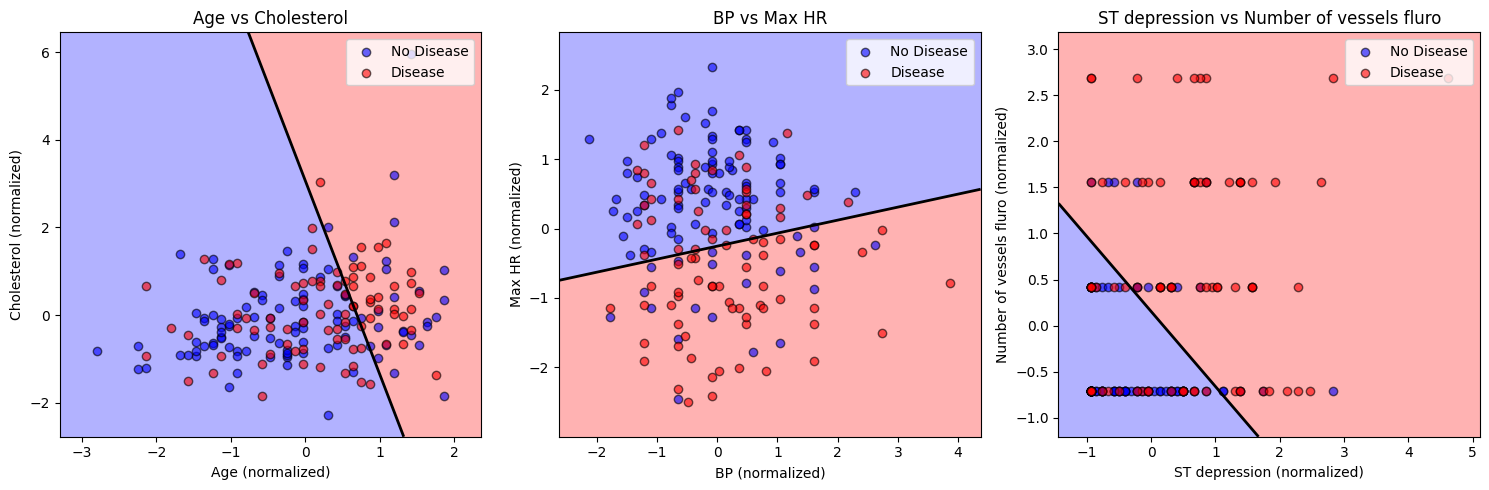

In [62]:
# plots for each feature pair
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (feat1, feat2) in enumerate(feature_pairs):

    i1 = features.index(feat1)
    i2 = features.index(feat2)
    
    X_2d = X_train_norm[:, [i1, i2]] # Extract 2D data (using normalized training data)

    
    # Train a new model with only 2 features
    w_2d = np.zeros(2)
    b_2d = 0
    w_2d, b_2d, _ = gradient_descent(X_2d, y_train, w_2d, b_2d, alpha=0.1, iterations=1000)
    
    # meshgrid for decision boundary
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Predict for each point in the grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = sigmoid(np.dot(grid_points, w_2d) + b_2d)
    Z = Z.reshape(xx.shape)
    
    # Plot
    ax = axes[idx]
    ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, colors=['blue', 'red'])
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Scatter plot of actual data points
    ax.scatter(X_2d[y_train == 0, 0], X_2d[y_train == 0, 1], 
               c='blue', label='No Disease', alpha=0.6, edgecolors='k')
    ax.scatter(X_2d[y_train == 1, 0], X_2d[y_train == 1, 1], 
               c='red', label='Disease', alpha=0.6, edgecolors='k')
    
    ax.set_xlabel(feat1 + ' (normalized)')
    ax.set_ylabel(feat2 + ' (normalized)')
    ax.set_title(f'{feat1} vs {feat2}')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

### 5.3 Analysis of each feature pair

In [63]:
print("Accuracy of 2D models (shows how separable each pair is):\n")

for feat1, feat2 in feature_pairs:
    i1 = features.index(feat1)
    i2 = features.index(feat2)
    
    X_2d_train = X_train_norm[:, [i1, i2]]
    X_2d_test = X_test_norm[:, [i1, i2]]
    
    # Train model
    w_2d = np.zeros(2)
    b_2d = 0
    w_2d, b_2d, _ = gradient_descent(X_2d_train, y_train, w_2d, b_2d, alpha=0.1, iterations=1000)
    
    # Predict
    y_pred_train = predict(X_2d_train, w_2d, b_2d)
    y_pred_test = predict(X_2d_test, w_2d, b_2d)
    
    # Accuracy
    acc_train = np.mean(y_pred_train == y_train) * 100
    acc_test = np.mean(y_pred_test == y_test) * 100
    
    print(f"{feat1} vs {feat2}:")
    print(f"  Train Accuracy: {acc_train:.1f}%")
    print(f"  Test Accuracy:  {acc_test:.1f}%")
    print()

Accuracy of 2D models (shows how separable each pair is):

Age vs Cholesterol:
  Train Accuracy: 56.6%
  Test Accuracy:  61.7%

BP vs Max HR:
  Train Accuracy: 70.4%
  Test Accuracy:  72.8%

ST depression vs Number of vessels fluro:
  Train Accuracy: 75.1%
  Test Accuracy:  77.8%



## 6. Logistic Regression with Regularization

**What is regularization?**
Regularization prevents the model from fitting the training data too closely (overfitting). It does this by adding a penalty for large weights.

**L2 Regularization (Ridge):**
- Adds a term $\frac{\lambda}{2m}\sum_{j=1}^n w_j^2$ to the cost function
- Makes the model prefer smaller weights
- λ (lambda) controls how much regularization to apply:
  - λ = 0: No regularization (same as before)
  - λ too high: Underfitting (model too simple)
  - λ optimal: Best balance

### 6.1 Cost function with L2 regularization

The regularized cost function is:

$$
J_{\text{reg}}(\vec{w}, b) =
\frac{1}{2m}\sum_{i=1}^m
\left(
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}
\right)^2
+
\frac{\lambda}{2m}\sum_{j=1}^n w_j^2.
$$

In [64]:
def compute_cost_reg(X, y, w, b, lambda_reg):
    m = len(y)
    
    z = np.dot(X, w) + b
    y_pred = sigmoid(z)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    cost = -1/m * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    # Add regularization term
    reg_term = (lambda_reg / (2 * m)) * np.sum(w ** 2)
    
    return cost + reg_term

### 6.2 Gradient descent with regularization

The gradient for weights now includes the regularization term:

$$\frac{\partial J_{reg}}{\partial w_j} = \frac{\partial J}{\partial w_j} + \frac{\lambda}{m} w_j$$

- We don't regularize the bias term (b).

In [65]:
def gradient_descent_reg(X, y, w, b, alpha, iterations, lambda_reg):
    m = len(y)
    cost_history = []
    
    for i in range(iterations):
        z = np.dot(X, w) + b
        y_pred = sigmoid(z)
        
        # Gradients with regularization (only for w, not b)
        dw = (1/m) * np.dot(X.T, (y_pred - y)) + (lambda_reg/m) * w
        db = (1/m) * np.sum(y_pred - y)
        
        w = w - alpha * dw
        b = b - alpha * db
        
        if i % 100 == 0:
            cost = compute_cost_reg(X, y, w, b, lambda_reg)
            cost_history.append(cost)
    
    return w, b, cost_history

### 6.3 Tune lambda values

We test different values of lambda to find the best one.

In [66]:
lambda_values = [0, 0.001, 0.01, 0.1, 1]

results = []

for lam in lambda_values:

    w_reg = np.zeros(n_features)
    b_reg = 0
    
    # Train with regularization
    w_reg, b_reg, cost_hist = gradient_descent_reg(X_train_norm, y_train, w_reg, b_reg, 
                                                    alpha=0.01, iterations=1000, lambda_reg=lam)
    
    # Predictions
    y_train_pred_reg = predict(X_train_norm, w_reg, b_reg)
    y_test_pred_reg = predict(X_test_norm, w_reg, b_reg)
    
    # Metrics
    train_acc, train_prec, train_rec, train_f1 = calculate_metrics(y_train, y_train_pred_reg)
    test_acc, test_prec, test_rec, test_f1 = calculate_metrics(y_test, y_test_pred_reg)
    
    # Norm of weights 
    w_norm = np.sqrt(np.sum(w_reg ** 2))
    
    results.append({
        'lambda': lam,
        'train_acc': train_acc * 100,
        'test_acc': test_acc * 100,
        'train_f1': train_f1 * 100,
        'test_f1': test_f1 * 100,
        'w_norm': w_norm,
        'w': w_reg.copy(),
        'b': b_reg,
        'cost_history': cost_hist
    })

### 6.4 Lambda vs Metrics table

In [67]:
lambda_df = pd.DataFrame({
    'Lambda': [r['lambda'] for r in results],
    'Train Acc (%)': [round(r['train_acc'], 2) for r in results],
    'Test Acc (%)': [round(r['test_acc'], 2) for r in results],
    'Train F1 (%)': [round(r['train_f1'], 2) for r in results],
    'Test F1 (%)': [round(r['test_f1'], 2) for r in results],
    '||w|| (norm)': [round(r['w_norm'], 4) for r in results]
})

print("Performance comparison for different λ values:")
lambda_df

Performance comparison for different λ values:


,Lambda,Train Acc (%),Test Acc (%),Train F1 (%),Test F1 (%),||w|| (norm)
0,0.000,77.25,85.19,72.26,82.86,1.1205
1,0.001,77.25,85.19,72.26,82.86,1.1205
2,0.010,77.25,85.19,72.26,82.86,1.1203
3,0.100,77.25,85.19,72.26,82.86,1.1183
4,1.000,77.25,85.19,72.26,82.86,1.0988


### 6.5 Find optimal lambda

In [68]:
best_idx = np.argmax([r['test_acc'] for r in results])
best_result = results[best_idx]
best_lambda = best_result['lambda']

no_reg_result = results[0] # Compare with no regularization (lambda=0)


print(f"Best λ = {best_lambda}")
print(f"\nComparison with no regularization (λ=0):")
print(f"  Test Accuracy: {no_reg_result['test_acc']:.2f}% → {best_result['test_acc']:.2f}%")
print(f"  Test F1 Score: {no_reg_result['test_f1']:.2f}% → {best_result['test_f1']:.2f}%")
print(f"  ||w|| norm:    {no_reg_result['w_norm']:.4f} → {best_result['w_norm']:.4f}")

Best λ = 0

Comparison with no regularization (λ=0):
  Test Accuracy: 85.19% → 85.19%
  Test F1 Score: 82.86% → 82.86%
  ||w|| norm:    1.1205 → 1.1205


### 6.6 Cost comparison: Regularized vs Unregularized

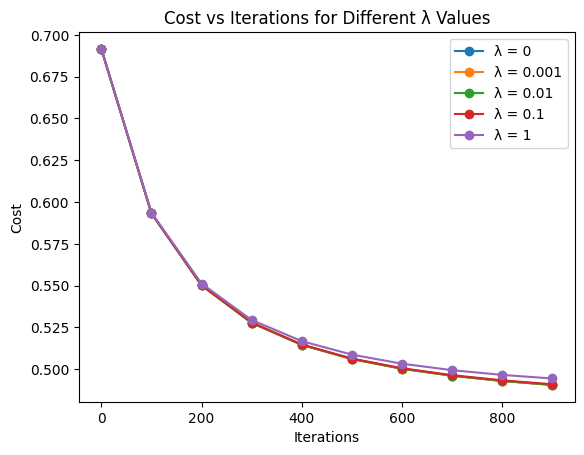

In [69]:
plt.figure()

for r in results:
    label = f"λ = {r['lambda']}"
    plt.plot(range(0, 1000, 100), r['cost_history'], label=label, marker='o')

plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost vs Iterations for Different λ Values")
plt.legend()
plt.show()

### 6.7 Decision boundary comparison: Unregularized vs Regularized

We compare decision boundaries for one feature pair (ST Depression vs Number of Vessels) with λ=0 and the best λ.

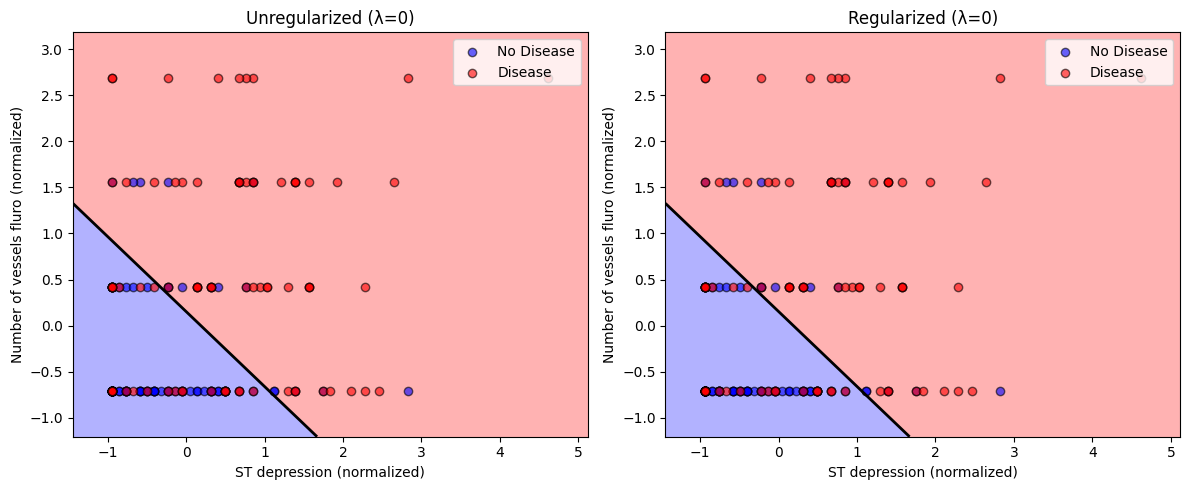

In [70]:
feat1, feat2 = 'ST depression', 'Number of vessels fluro'
i1 = features.index(feat1)
i2 = features.index(feat2)

X_2d = X_train_norm[:, [i1, i2]]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

lambdas_to_compare = [0, best_lambda]
titles = ['Unregularized (λ=0)', f'Regularized (λ={best_lambda})']

for idx, lam in enumerate(lambdas_to_compare):
    # Train 2D model
    w_2d = np.zeros(2)
    b_2d = 0
    w_2d, b_2d, _ = gradient_descent_reg(X_2d, y_train, w_2d, b_2d, 
                                          alpha=0.1, iterations=1000, lambda_reg=lam)
    
    # Create meshgrid
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = sigmoid(np.dot(grid_points, w_2d) + b_2d)
    Z = Z.reshape(xx.shape)
    
    ax = axes[idx]
    ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, colors=['blue', 'red'])
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    ax.scatter(X_2d[y_train == 0, 0], X_2d[y_train == 0, 1], 
               c='blue', label='No Disease', alpha=0.6, edgecolors='k')
    ax.scatter(X_2d[y_train == 1, 0], X_2d[y_train == 1, 1], 
               c='red', label='Disease', alpha=0.6, edgecolors='k')
    
    ax.set_xlabel(feat1 + ' (normalized)')
    ax.set_ylabel(feat2 + ' (normalized)')
    ax.set_title(titles[idx])
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

### 6.8 Weight comparison: Effect of regularization

In [71]:
weights_comparison = pd.DataFrame({
    'Feature': features,
    'w (λ=0)': results[0]['w'].round(4),
    f'w (λ={best_lambda})': best_result['w'].round(4)
})

print("Weight comparison - Regularization shrinks weights towards zero:")
weights_comparison

Weight comparison - Regularization shrinks weights towards zero:


,Feature,w (λ=0)
0,Age,-0.0719
1,Cholesterol,0.0933
2,BP,0.1039
3,Max HR,-0.5774
4,ST depression,0.5613
5,Number of vessels fluro,0.7631
